<a href="https://colab.research.google.com/github/dsibi/practicum_data_example_repo/blob/master/ads_for_sale_of_apartments_research/ads_for_sale_of_apartments_research.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

## Шаг 1. Откроем файл с данными и изучим общую информацию

Импортируем необходимые библиотеки

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Читаем и выводим на экран данные по датасету

In [ ]:
df=pd.read_csv('./data/real_estate_data.csv', sep='\t')
df.info()
print(df.isna().sum())
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23699.000000,2.369900e+04,23699.000000,23699.000000,14504.000000,23613.000000,21796.000000,23699.000000,21421.000000,12180.000000,18157.000000,18180.000000,18181.000000,8079.000000,18181.000000,9110.000000,20518.000000
mean,9.858475,6.541549e+06,60.348651,2.070636,2.771499,10.673824,34.457852,5.892358,10.569807,1.150082,28793.672193,14191.277833,0.611408,490.804555,0.770255,517.980900,180.888634
std,5.682529,1.088701e+07,35.654083,1.078405,1.261056,6.597173,22.030445,4.885249,5.905438,1.071300,12630.880622,8608.386210,0.802074,342.317995,0.938346,277.720643,219.727988
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.520000,5.000000,18.600000,2.000000,7.000000,0.000000,18585.000000,9238.000000,0.000000,288.000000,0.000000,294.000000,45.000000
50%,9.000000,4.650000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.100000,1.000000,26726.000000,13098.500000,0.000000,455.000000,1.000000,502.000000,95.000000
75%,14.000000,6.800000e+06,69.900000,3.000000,2.800000,16.000000,42.300000,8.000000,12.000000,2.000000,37273.000000,16293.000000,1.000000,612.000000,1.000000,729.000000,232.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


### Вывод

Файл открыли и изучли - он содержит таблицу, состоящую 23699 строк и 21 колонки:
- в таблице имеются пропуски;
- есть колонки с некорректным типом данных;
- данные в следущих колонках требуют дополнительного анализа на предмет их корректности: `total_area`, `rooms`, `ceiling_height`, `floors_total`, `living_area`, `kitchen_area`, `airports_nearest`.

## Шаг 2. Предобработка данных

### Определение и изучение пропущенных значений

#### Считаем доли пропусков

Создадим таблицу с указанием доли пропусков по каждой колонке и отсортируем значения по убыванию доли пропусков

In [ ]:
miss_value=pd.DataFrame(df.isna().mean()).reset_index()
miss_value.set_axis(['column_name', 'missing_value'], axis = 'columns', inplace = True)
miss_value.sort_values(by='missing_value', ascending=False).style.format({ 'missing_value': '{:,.2%}'.format})

,column_name,missing_value
9,is_apartment,88.29%
18,parks_nearest,65.91%
20,ponds_nearest,61.56%
13,balcony,48.61%
5,ceiling_height,38.80%
15,airports_nearest,23.38%
16,cityCenters_nearest,23.29%
19,ponds_around3000,23.28%
17,parks_around3000,23.28%
21,days_exposition,13.42%


Пропуски содержатся более чем в половине колонок, будем действовать по следующему сценарию:
1. Удалим строки с долей пропусков менее 1 %
2. По порядку будем заполнять пропуски в остальных колонках

##### Удаление строк с долей пропусков менее 1 %

In [ ]:
df=df.dropna(subset=['locality_name','floors_total'])

##### Обработка пропусков в остальных колонках

Большое количество пропусков в колонке `is_apartment` вероятнее всего говорит о том, что на этапе ввода данных, значения в этом поле не устанавливали, если объект не являлся апартаментами, но для того, чтобы не искажать данные заменим пока их на некий третий тип данных (цифру `2`), которые далее проанализируем отдельно.

In [ ]:
df['is_apartment']=df['is_apartment'].fillna(2)

Пропуски в колонках parks_nearest и parks_around3000 вероятнее всего вызваны технической ошибкой. Колонки parks_nearest и parks_around3000 связаны между собой. Выведем пустые значения по колонке parks_around3000 и проверим значения в колонке parks_nearest

In [ ]:
print(df.loc[df['parks_around3000'].isna()]['parks_nearest'].unique())

[nan]


Т.к. значения отсутствуют в обеих колонках, то заменим пропуски в колонке parks_around3000 на 0

In [ ]:
df['parks_around3000']=df['parks_around3000'].fillna(value=0)

Выведем нулевые значения по колонке parks_around3000 и проверим значения в колонке parks_nearest

In [ ]:
print(df.loc[df['parks_around3000']==0]['parks_nearest'].unique())

[  nan 3064. 3190. 3013.]


Выведем строки с пустыми значениями по колонке parks_nearest и проверим значения в колонке parks_around3000

In [ ]:
print(df.loc[df['parks_nearest'].isna()]['parks_around3000'].unique())

[0.]


Т.к. все пропуски в колонке parks_nearest соответствуют нулевым значениям в колонке parks_around3000, то у нас достаточно выводов для проведения группировок по колонке parks_nearest и сохранения данных в новой колонке parks_nearest_groups

In [ ]:
def park_or_lake_nearest (dist):
    if dist <= 500:
        return "до 500"
    elif dist <= 1500:
        return "от 501 до 1500"
    elif dist <= 3000:
        return "от 1501 до 3000"
    else:
        return "свыше 3001"
df['parks_nearest_groups'] = df['parks_nearest'].apply(park_or_lake_nearest)

Колонки по данным с прудами обрабатываем аналогичным образом

In [ ]:
df['ponds_around3000']=df['ponds_around3000'].fillna(value=0)
df['ponds_nearest_groups'] = df['ponds_nearest'].apply(park_or_lake_nearest)

Пропуски по числу балконов заменим на 0, т.к. если человек не указал число балконов, то скорее всего, их нет

In [ ]:
df['balcony']=df['balcony'].fillna(value=0)

Пропуски по высоте потолков вызваны главным образом техническим фактором, в меньшей степени - человек точного значения не знал и пропускал это поле при заполнении, заменим на их модальное значение.

In [ ]:
df['ceiling_height']=df['ceiling_height'].fillna(value=df['ceiling_height'].mode()[0])

Пропуски по удаленности от ближайшего аэропорта вероятнее всего вызваны технической ошибкой, заполним медианными значениями в соответствии с locality_name

In [ ]:
distance_med=df.groupby('locality_name')['airports_nearest'].median()
for locality_name in distance_med.index:
    df.loc[(df['airports_nearest'].isna()) & (df['locality_name'] == locality_name), 'airports_nearest'] = distance_med.loc[locality_name]

Проверяем текущее состояние по пропускам.

In [ ]:
miss_value=pd.DataFrame(df.isna().mean()).reset_index()
miss_value.set_axis(['column_name', 'missing_value'], axis = 'columns', inplace = True)
miss_value.sort_values(by='missing_value', ascending=False).style.format({ 'missing_value': '{:,.2%}'.format})

,column_name,missing_value
18,parks_nearest,65.92%
20,ponds_nearest,61.65%
16,cityCenters_nearest,23.34%
15,airports_nearest,23.05%
21,days_exposition,13.46%
12,kitchen_area,9.43%
7,living_area,7.91%
13,balcony,0.00%
22,parks_nearest_groups,0.00%
19,ponds_around3000,0.00%


По airports_nearest сохраняется большая доля пропусков, посмотрим диапазон данных в столбце, произведем группировку и введем значение "неизвестно" там, где данные отсутствуют

In [ ]:
print('минимальное значение - ', (min(df['airports_nearest'])),'\n','максимальное значение - ', (max(df['airports_nearest'])), sep='')

минимальное значение - 0.0
максимальное значение - 84869.0


In [ ]:
def airports_nearest_group (dist):
    if dist <= 10000:
        return "до 10000"
    elif dist <= 50000:
        return "от 10001 до 50000"
    elif dist > 50000:
        return "свыше 51000"
    else:
        return "неизвестно"
df['airports_nearest_groups'] = df['airports_nearest'].apply(airports_nearest_group)

Пропуски по расстоянию до центра города обработаем аналогично пропускам в airports_nearest

In [ ]:
distance_med=df.groupby('locality_name')['cityCenters_nearest'].median()
for locality_name in distance_med.index:
    df.loc[(df['cityCenters_nearest'].isna()) & (df['locality_name'] == locality_name), 'cityCenters_nearest'] = distance_med.loc[locality_name]
print('минимальное значение - ', (min(df['cityCenters_nearest'])),'\n','максимальное значение - ', (max(df['cityCenters_nearest'])), sep='')

минимальное значение - 181.0
максимальное значение - 65968.0


In [ ]:
def cityCenters_nearest_group (dist):
    if dist <= 3000:
        return "до 3000"
    elif dist <= 10000:
        return "от 3001 до 10000"
    elif dist > 10000:
        return "свыше 11000"
    else:
        return "неизвестно"
df['city_center_nearest_group'] = df['cityCenters_nearest'].apply(cityCenters_nearest_group)

Пропуски по количеству дней от публикации до снятия объявления вероятнее всего вызваны технической ошибкой. Значения в колонке по количеству дней от публикации до снятия объявления сгруппируем в новой колонке, пропуски заполним значением "неизвестно"

In [ ]:
def days_exposition_group (days):
    if days <= 30:
        return "до 30"
    elif days <= 180:
        return "от 31 до 180"
    elif days > 180:
        return "свыше 180"
    else:
        return "неизвестно"
df['days_exposition_group'] = df['days_exposition'].apply(days_exposition_group)

Пропуски по площади кухонь главным образом техническим фактором, в меньшей степени - человек точного значения не знал и пропускал это поле при заполнении. Пропуски для студий заполним нулями, оставшиеся - медианным значением по locality_name

In [ ]:
df.loc[df['studio'] == 1, 'kitchen_area'] = 0
kitchen_med=df.groupby('locality_name')['kitchen_area'].median()
for locality_name in kitchen_med.index:
    df.loc[(df['kitchen_area'].isna()) & (df['locality_name'] == locality_name), 'kitchen_area'] = kitchen_med.loc[locality_name]
print('Осталось пустых записей -', len(df[df['kitchen_area'].isna()]))

Осталось пустых записей - 18


In [ ]:
df=df.dropna(subset=['kitchen_area'])

Пропуски по жилой площади главным образом техническим фактором, в меньшей степени - человек точного значения не знал и пропускал это поле при заполнении, заполним их медианным значением в зависимости от living_area и rooms

In [ ]:
living_med = df.groupby('rooms')['living_area'].median()
for rooms_number in living_med.index:
    df.loc[(df['rooms'] == rooms_number), 'living_area'] = df.loc[(df['rooms'] == rooms_number),'living_area'].fillna(living_med[rooms_number])

Проверим результаты заполнения пропусков

In [ ]:
miss_value=pd.DataFrame(df.isna().mean()).reset_index()
miss_value.set_axis(['column_name', 'missing_value'], axis = 'columns', inplace = True)
miss_value.sort_values(by='missing_value', ascending=False).style.format({ 'missing_value': '{:,.2%}'.format})

,column_name,missing_value
18,parks_nearest,65.90%
20,ponds_nearest,61.63%
16,cityCenters_nearest,23.00%
15,airports_nearest,23.00%
21,days_exposition,13.46%
0,total_images,0.00%
14,locality_name,0.00%
25,city_center_nearest_group,0.00%
24,airports_nearest_groups,0.00%
23,ponds_nearest_groups,0.00%


Итоговый размер датасета после обработки пропусков

In [ ]:
df.shape

(23547, 27)

### Приведение данных к нужным типам

Выведем текущие столбы по датасету и ознакомимся с их типом данных

In [ ]:
df.dtypes

total_images                   int64
last_price                   float64
total_area                   float64
first_day_exposition          object
rooms                          int64
ceiling_height               float64
floors_total                 float64
living_area                  float64
floor                          int64
is_apartment                  object
studio                          bool
open_plan                       bool
kitchen_area                 float64
balcony                      float64
locality_name                 object
airports_nearest             float64
cityCenters_nearest          float64
parks_around3000             float64
parks_nearest                float64
ponds_around3000             float64
ponds_nearest                float64
days_exposition              float64
parks_nearest_groups          object
ponds_nearest_groups          object
airports_nearest_groups       object
city_center_nearest_group     object
days_exposition_group         object
d

Заменим вещественный тип данных на целочисленный во всех столбцах, кроме столбцов с данными о площадях помещений

In [ ]:
for col in ['last_price', 'ceiling_height', 'floors_total', 'balcony', 'parks_around3000', 'ponds_around3000']:
    df[col]=df[col].astype('int')

Преобразуем тип данных в колонке first_day_exposition в формат даты

In [ ]:
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format='%Y%m%dT%H:%M:%S')

In [ ]:
print(df.dtypes)

total_images                          int64
last_price                            int32
total_area                          float64
first_day_exposition         datetime64[ns]
rooms                                 int64
ceiling_height                        int32
floors_total                          int32
living_area                         float64
floor                                 int64
is_apartment                         object
studio                                 bool
open_plan                              bool
kitchen_area                        float64
balcony                               int32
locality_name                        object
airports_nearest                    float64
cityCenters_nearest                 float64
parks_around3000                      int32
parks_nearest                       float64
ponds_around3000                      int32
ponds_nearest                       float64
days_exposition                     float64
parks_nearest_groups            

### Удалим дубликаты

In [ ]:
print(df.shape)
key = ['total_area', 'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor', 'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony', 'locality_name', 'first_day_exposition']
df = df.drop_duplicates(subset=key)
print(df.shape)

(23547, 27)
(23544, 27)


Теперь в датасете отсутствуют дубликаты, пропущенные значения, также они приведены к корректному типу данных. На этом этап предобработки данных завершен.

## Шаг 3. Посчитаем и добавим в таблицу дополнительные сведения

### Цена квадратного метра

In [ ]:
df['square_price']=df['last_price']/df['total_area']

### День недели, месяц и год публикации объявления

In [ ]:
df['exp_weekday']=df['first_day_exposition'].dt.weekday.astype('str').map({'0': 'Пн', '1': 'Вт', '2': 'Ср', '3': 'Чт', '4': 'Пт', '5': 'Сб', '6': 'Вс'})
df['exp_month']=df['first_day_exposition'].dt.month.astype('str').map({'1': 'ЯНВ', '2': 'ФЕВ', '3': 'МАР', '4': 'АПР', '5': 'МАЙ', '6': 'ИЮН', '7': 'ИЮЛ', '8': 'АВГ', '9': 'СЕНТ', '10': 'ОКТ', '11': 'НОЯ', '12': 'ДЕК'})
df['exp_year']=df['first_day_exposition'].dt.year

### Этаж квартиры

Перед группировкой проверим есть ли квартиры в одноэтажных домах

In [ ]:
len(df.loc[df['floors_total']==1])

23

При группировке примем отнесем их к квартирам на первом этаже

In [ ]:
# df['first_floor']=(df['floor']==1)*1

# def last_floor(row):
#     if row['floor'] == 1:
#         return 0
#     elif row['floor'] == row['floors_total']:
#         return 1
#     return 0
# df['last_floor'] = df.apply(last_floor, axis=1)
# # df['last_floor']=(df['floor']==df['floors_total'])*1
# def other_floor(row):
#     if row['first_floor'] == 1:
#         return 0
#     elif row['last_floor'] == 1:
#         return 0
#     return 1
# df['other_floor'] = df.apply(other_floor, axis=1)

In [ ]:
def floor_groups(row):
    if row['floor'] == 1:
        return 'первый этаж'
    elif row['floor'] == row['floors_total']:
        return 'последний этаж'
    return 'другой этаж'
df['floor_groups'] = df.apply(floor_groups, axis=1)

### Соотношение жилой и общей площади, а также отношение площади кухни к общей площади

In [ ]:
df['living_area_to_total_area']=df['living_area']/df['total_area']
print(df['living_area'].corr(df['total_area']).round(2))
df['kitchen_area_to_total_area']=df['kitchen_area']/df['total_area']
print(df['kitchen_area'].corr(df['total_area']).round(2))

0.91
0.57


## Шаг 4. Проведем исследовательский анализ данных

### Изучим площадь, цену, число комнат и высоту потолков, удалим по ним редкие и выбивающиеся значения

#### Площадь

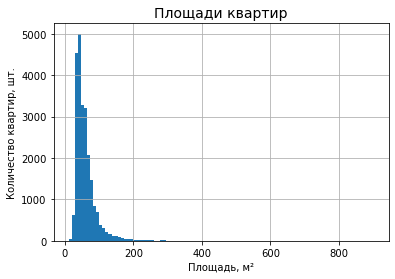

In [ ]:
df.hist('total_area', bins=100)
plt.title('Площади квартир', size=14)
plt.xlabel('Площадь, м²')
plt.ylabel('Количество квартир, шт.')
plt.show()

Пик наблюдений на отметке 30-50 и почти нулевые значения от 300. Построим коробчатую диаграмму

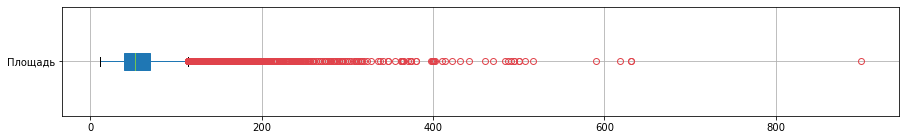

In [ ]:
ax=df.boxplot('total_area', vert=False, figsize=(15,2), patch_artist=True, flierprops=dict(markeredgecolor="#e0434b"),
            medianprops=dict(color='#71c451'))
ax.set_yticklabels(['Площадь'])
plt.show()

Удалим явные выбросы

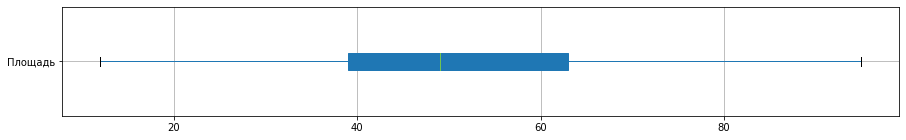

In [ ]:
df.drop(df[df['total_area'] > 95].index, inplace=True)
ax=df.boxplot('total_area', vert=False, figsize=(15,2), patch_artist=True, flierprops=dict(markeredgecolor="#e0434b"),
            medianprops=dict(color='#71c451'))
ax.set_yticklabels(['Площадь'])
plt.show()

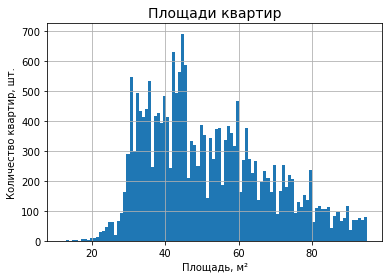

In [ ]:
df.hist('total_area', bins=100)
plt.title('Площади квартир', size=14)
plt.xlabel('Площадь, м²')
plt.ylabel('Количество квартир, шт.')
plt.show()

#### Цена

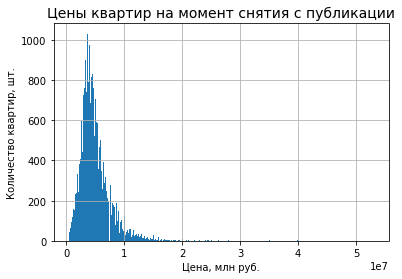

In [ ]:
df.hist('last_price', bins=300)
plt.title('Цены квартир на момент снятия с публикации', size=14)
plt.xlabel('Цена, млн руб.')
plt.ylabel('Количество квартир, шт.')
plt.show()

Пик наблюдений на отметке 4,0-4,5 млн руб. Построим коробчатую диаграмму

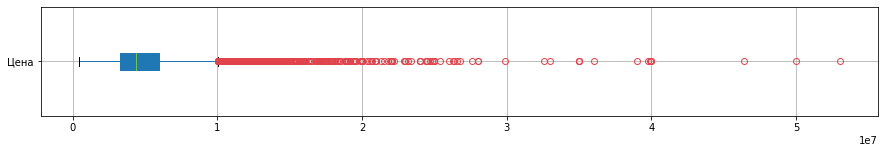

In [ ]:
ax=df.boxplot('last_price', vert=False, figsize=(15,2), patch_artist=True, flierprops=dict(markeredgecolor="#e0434b"),
            medianprops=dict(color='#71c451'))
ax.set_yticklabels(['Цена'])
plt.show()

Удалим явные выбросы

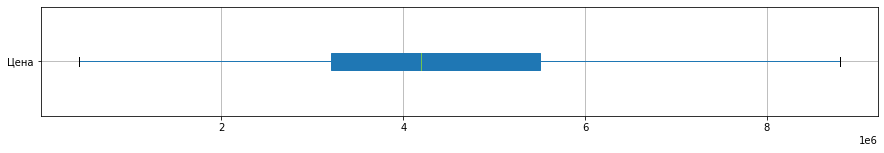

In [ ]:
df.drop(df[df['last_price'] > 8800000].index, inplace=True)
df.drop(df[df['last_price'] < 200000].index, inplace=True)
ax=df.boxplot('last_price', vert=False, figsize=(15,2), patch_artist=True, flierprops=dict(markeredgecolor="#e0434b"),
            medianprops=dict(color='#71c451'))
ax.set_yticklabels(['Цена'])
plt.show()

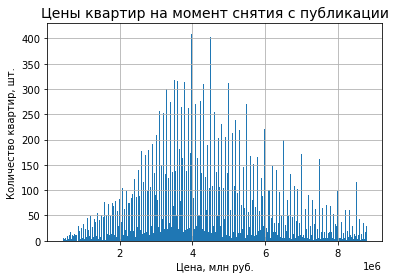

In [ ]:
df.hist('last_price', bins=300)
plt.title('Цены квартир на момент снятия с публикации', size=14)
plt.xlabel('Цена, млн руб.')
plt.ylabel('Количество квартир, шт.')
plt.show()

#### Число комнат

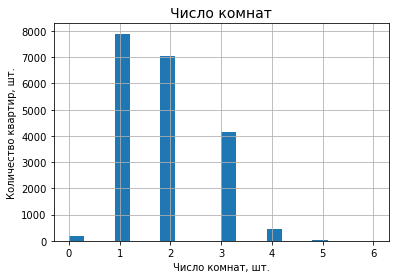

In [ ]:
df.hist('rooms', bins=20)
plt.title('Число комнат', size=14)
plt.xlabel('Число комнат, шт.')
plt.ylabel('Количество квартир, шт.')
plt.show()

Пик наблюдений на отметке в 1 комнату, почти нулевые значения по 5 и 6 комнатам. Странно выглядят данные по квартирам с 0 комнатами, удалим их.

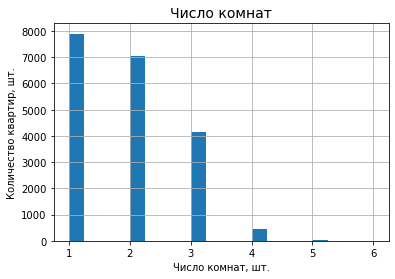

In [ ]:
df.drop(df[df['rooms'] < 1 ].index, inplace=True)
df.hist('rooms', bins=20)
plt.title('Число комнат', size=14)
plt.xlabel('Число комнат, шт.')
plt.ylabel('Количество квартир, шт.')
plt.show()

#### Высота потолков

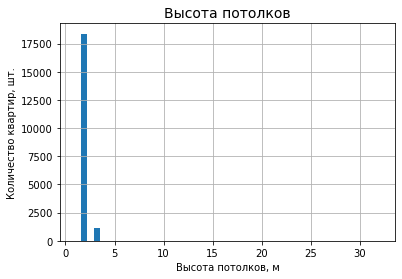

In [ ]:
df.hist('ceiling_height', bins=50)
plt.title('Высота потолков', size=14)
plt.xlabel('Высота потолков, м')
plt.ylabel('Количество квартир, шт.')
plt.show()

Пик наблюдений на отметке в 2-3 метра, но существуют странные данные по высоте более 30 метров, посмотрим на них на коробчатой диаграмме

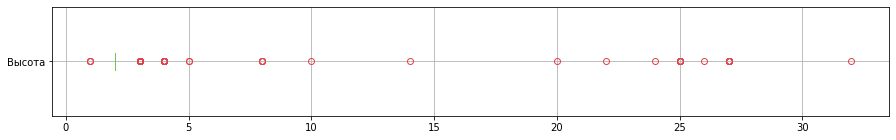

In [ ]:
ax=df.boxplot('ceiling_height', vert=False, figsize=(15,2), patch_artist=True, flierprops=dict(markeredgecolor="#e0434b"),
            medianprops=dict(color='#71c451'))
ax.set_yticklabels(['Высота'])
plt.show()

Как видим по высоте есть выбросы в обе стороны от нормального распределения, удалим явные выбросы

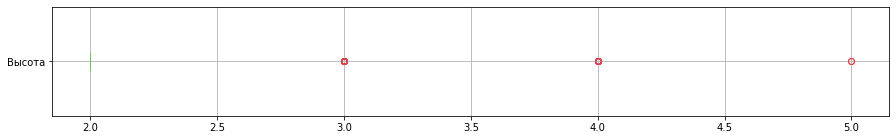

In [ ]:
df.drop(df[df['ceiling_height'] > 5].index, inplace=True)
df.drop(df[df['ceiling_height'] < 1.5].index, inplace=True)
ax=df.boxplot('ceiling_height', vert=False, figsize=(15,2), patch_artist=True, flierprops=dict(markeredgecolor="#e0434b"),
            medianprops=dict(color='#71c451'))
ax.set_yticklabels(['Высота'])
plt.show()

### Изучим время продажи квартиры

Посчитаем среднее и медиану

In [ ]:
print(df['days_exposition'].mean())
print(df['days_exposition'].median())

168.63026376677465
89.00000000000001


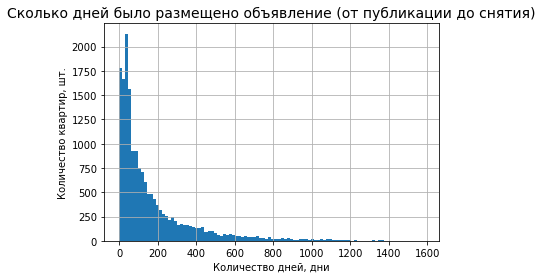

In [ ]:
df.hist('days_exposition', bins=100)
plt.title('Сколько дней было размещено объявление (от публикации до снятия)', size=14)
plt.xlabel('Количество дней, дни')
plt.ylabel('Количество квартир, шт.')
plt.show()

Есть пик в районе 45 дней, продажи на отметке 800 дней уже редки. По прошествии 1000 дней продаж почти нет. А на участке более 1400 секунд гистограмма сливается с нулём (это не значит, что там ровно 0, но таких продаж единицы). Чтобы изучить особенность поближе, построим коробчатую диаграмму.

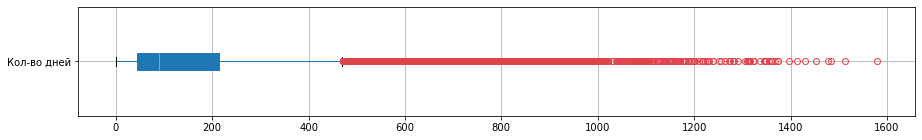

In [ ]:
ax=df.boxplot('days_exposition', vert=False, figsize=(15,2), patch_artist=True, flierprops=dict(markeredgecolor="#e0434b"),
            medianprops=dict(color='#71c451'))
ax.set_yticklabels(['Кол-во дней'])
plt.show()

Наблюдаем ярко выраженную долю выбросов, которые будем удалять

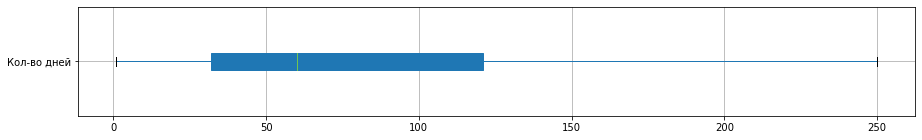

In [ ]:
df.drop(df[df['days_exposition'] > 250 ].index, inplace=True)
ax=df.boxplot('days_exposition', vert=False, figsize=(15,2), patch_artist=True, flierprops=dict(markeredgecolor="#e0434b"),
            medianprops=dict(color='#71c451'))
ax.set_yticklabels(['Кол-во дней'])
plt.show()

82.0
60.0


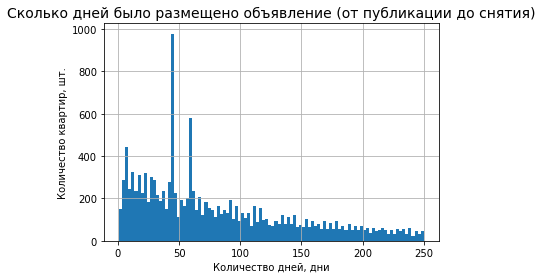

In [ ]:
print(df['days_exposition'].mean().round(0))
print(df['days_exposition'].median().round(0))
df.hist('days_exposition', bins=100)
plt.title('Сколько дней было размещено объявление (от публикации до снятия)', size=14)
plt.xlabel('Количество дней, дни')
plt.ylabel('Количество квартир, шт.')
plt.show()

50 % квартир продаются в течение 82 дней, в среднем время продажи составляет - 60 дней - по прошествии этого времени наблюдается спад продаж.

### Какие факторы больше всего влияют на стоимость квартиры?

#### Зависимость цены от площади квартиры

0.61


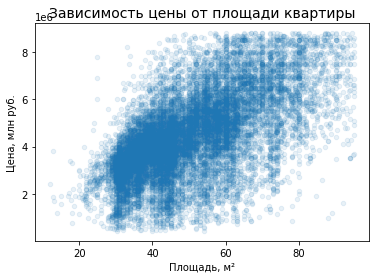

In [ ]:
print(df['last_price'].corr(df['total_area']).round(2))
df.plot(x='total_area', y='last_price', kind='scatter', alpha=0.1)
plt.title('Зависимость цены от площади квартиры', size=14)
plt.xlabel('Площадь, м²')
plt.ylabel('Цена, млн руб.')
plt.show()

Имеется средне-положительная линейная зависимость, основной массив данных наблюдается в диапазонах от 30 до 45 кв. метров и стоимости 3-4,3 млн руб. соответственно

#### Зависимость цены от числа комнат

0.37


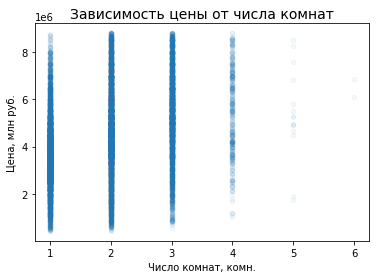

In [ ]:
print(df['last_price'].corr(df['rooms']).round(2))
df.plot(x='rooms', y='last_price', kind='scatter', alpha=0.05)
plt.title('Зависимость цены от числа комнат', size=14)
plt.xlabel('Число комнат, комн.')
plt.ylabel('Цена, млн руб.')
plt.show()

Зависимость слабая. Основной массив данных наблюдается по квартирам с 1-3 комнатами.

#### Зависимость цены от удалённости от центра

-0.31


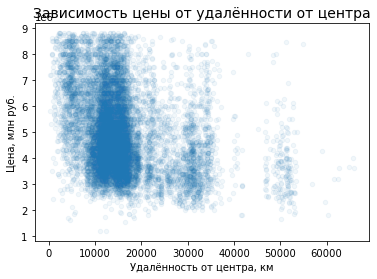

In [ ]:
print(df['cityCenters_nearest'].corr(df['last_price']).round(2))
df.plot(x='cityCenters_nearest', y='last_price', kind='scatter', alpha=0.06)
plt.title('Зависимость цены от удалённости от центра', size=14)
plt.xlabel('Удалённость от центра, км')
plt.ylabel('Цена, млн руб.')
plt.show()

Видим слабо-отрицательную зависимость, когда при удалении от центра происходит снижение цены.

#### Зависимость цены от этажа, на котором расположена квартира: первом, последнем или другом

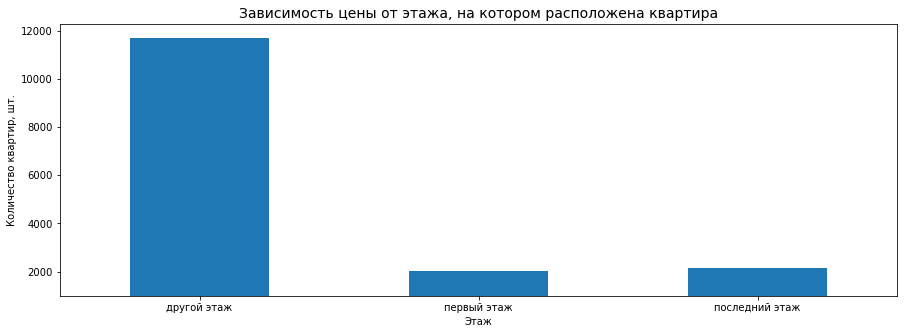

In [ ]:
floors=df.pivot_table(index='floor_groups', values='last_price', aggfunc='count')
ax=floors.plot(kind='bar', figsize=(15, 5),rot=360)
plt.ylim(bottom=1000)
ax.legend_.remove()
plt.title('Зависимость цены от этажа, на котором расположена квартира', size=14)
plt.xlabel('Этаж')
plt.ylabel('Количество квартир, шт.')
plt.show()

При покупке квартир люди отдают свое предпочение квартирам не на первом и последнем этажах

#### Зависимость цены от  даты размещения: дня недели, месяца и года

##### День недели

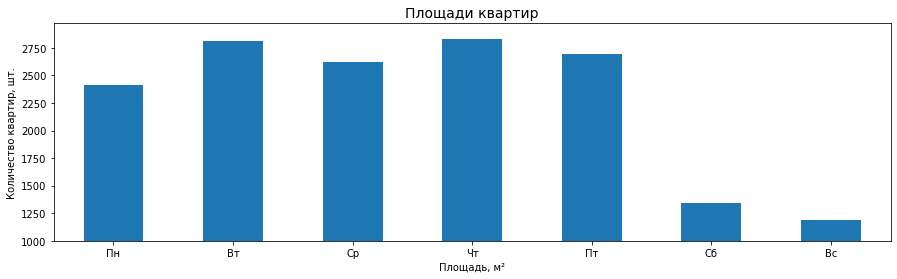

In [ ]:
exp_weekday=df.pivot_table(index='exp_weekday', values='last_price', aggfunc='count').reset_index()
days = ['Пн','Вт','Ср','Чт','Пт','Сб', 'Вс']
mapping = {day: i for i, day in enumerate(days, 1)}
key = exp_weekday['exp_weekday'].map(mapping)
exp_weekday = exp_weekday.iloc[key.argsort()].set_index('exp_weekday')
ax=exp_weekday.plot(kind='bar', figsize=(15, 4),rot=360)
plt.ylim(bottom=1000)
ax.legend_.remove()
plt.title('Площади квартир', size=14)
plt.xlabel('Площадь, м²')
plt.ylabel('Количество квартир, шт.')
plt.show()

Количество продаж резко снижается в выходные дни, понедельник-день тяжелый, средец-недели венец, ну и пятница-развратница - ничего нового )

##### Месяц

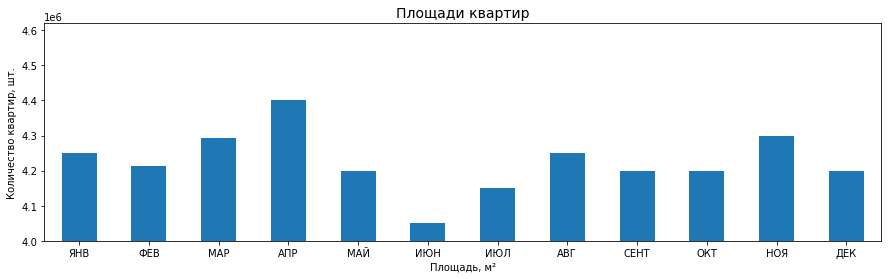

In [ ]:
df.pivot_table(index='exp_month', values='last_price', aggfunc='count')
exp_month=df.pivot_table(index='exp_month', values='last_price', aggfunc='median').reset_index()
months = ['','ЯНВ',  'ФЕВ', 'МАР', 'АПР', 'МАЙ', 'ИЮН',  'ИЮЛ', 'АВГ',  'СЕНТ',  'ОКТ',  'НОЯ',  'ДЕК']
mapping = {month: i for i, month in enumerate(months)}
key = exp_month['exp_month'].map(mapping)
exp_month = exp_month.iloc[key.argsort()].set_index('exp_month')
ax=exp_month.plot(kind='bar', figsize=(15, 4),rot=360)
plt.ylim(bottom=4000000)
ax.legend_.remove()
plt.title('Площади квартир', size=14)
plt.xlabel('Площадь, м²')
plt.ylabel('Количество квартир, шт.')
plt.show()

Пик продаж наблюдаем в апреле, далее в сезон отпусков рынок "проседает" и возвращается к жизни к концу календарного года

##### Год

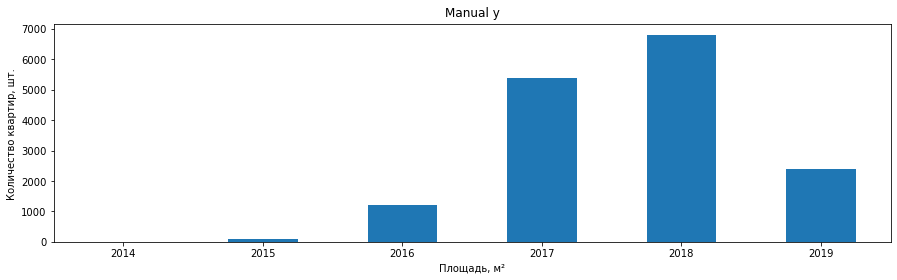

In [ ]:
exp_year=df.pivot_table(index='exp_year' , values='last_price', aggfunc='count')
ax=exp_year.plot(kind='bar', figsize=(15, 4),rot=360)
plt.title('Площади квартир', size=14)
ax.set_title('Manual y', y=1.1, pad=-14)
ax.legend_.remove()
plt.xlabel('Площадь, м²')
plt.ylabel('Количество квартир, шт.')
plt.show()

Низке количество продаж за 2014-2016 и 2019 годы вызвано вероятно всего тем, что в датасет попали не все данные по этим годам. Данные за 2017 и 2018 гг. выглядят правдоподобно

### Выделим 10 населённых пунктов с наибольшим числом объявлений

In [ ]:
top_exp=(df.groupby('locality_name')['square_price'].agg(['mean', 'count'])).sort_values(by='count', ascending=False).head(10)
top_exp

,mean,count
locality_name,,
Санкт-Петербург,104029.009319,9826
посёлок Мурино,85649.789674,413
посёлок Шушары,78739.425869,353
Всеволожск,66939.224122,290
Колпино,75438.450393,281
посёлок Парголово,90260.447430,260
Пушкин,99245.334697,244
Гатчина,69068.025480,232
деревня Кудрово,92257.296506,208


In [ ]:
df['locality_name'] = df['locality_name'].str.replace('посёлок ', '')
df['locality_name'] = df['locality_name'].str.replace('деревня ', '')
top_exp=(df.groupby('locality_name')['square_price'].agg(['mean', 'count'])).sort_values(by='count', ascending=False).head(10)
top_exp

,mean,count
locality_name,,
Санкт-Петербург,104029.009319,9826
Мурино,86173.256227,445
Кудрово,95336.172901,355
Шушары,78739.425869,353
Всеволожск,66939.224122,290
Колпино,75438.450393,281
Парголово,90260.447430,260
Пушкин,99245.334697,244
Гатчина,69068.025480,232


Посчитаем среднюю цену квадратного метра в этих населённых пунктах

In [ ]:
print(top_exp['mean'].mean().round(1))

82401.6


Выделим населённые пункты с самой высокой и низкой стоимостью жилья

In [ ]:
print(top_exp.sort_values(by='mean', ascending=False).head(3))
print(top_exp.sort_values(by='mean', ascending=False).tail(3))

                          mean  count
locality_name                        
Санкт-Петербург  104029.009319   9826
Пушкин            99245.334697    244
Кудрово           95336.172901    355
                       mean  count
locality_name                     
Гатчина        69068.025480    232
Всеволожск     66939.224122    290
Выборг         58786.985332    179


### Изучим предложения квартир

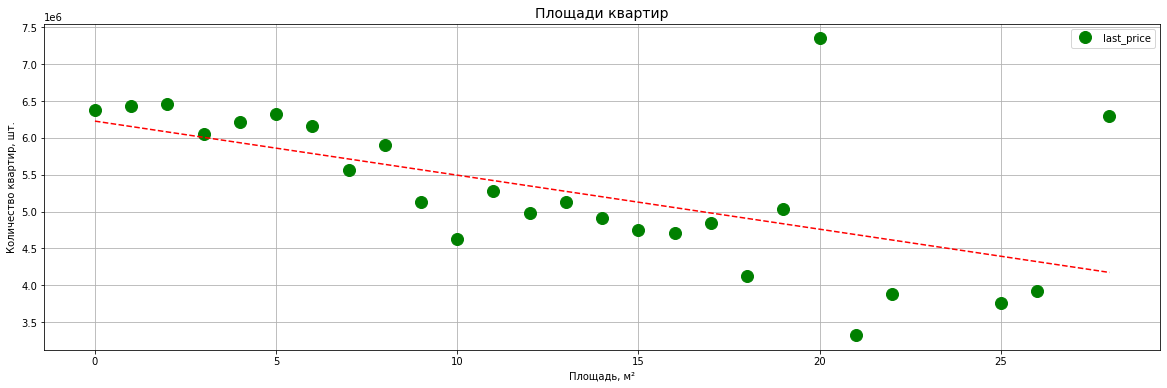

In [ ]:
spb=df.query('locality_name == "Санкт-Петербург"')
spb=spb.dropna()
spb['cityCenters_nearest_km']=(spb['cityCenters_nearest']/1000).round(0)
spb_plot=spb.groupby(['cityCenters_nearest_km']).agg({'last_price' : 'mean'})
spb_plot.plot(figsize = (20,6), style ='go', markersize=12, grid=True)

x = spb_plot.index 
y = spb_plot['last_price']
 
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")
plt.title('Площади квартир', size=14)
plt.xlabel('Площадь, м²')
plt.ylabel('Количество квартир, шт.')
plt.show()

Из графика видно, что цены за квадратный метр квартир начинают идти вниз от отметки в 6 км - примем этот расстояние за центр города

### Выделим сегмент квартир в центре

In [ ]:
# spb=spb.query('cityCenters_nearest_km <= 5')
# columns1 = ['last_price', 'total_area','rooms', 'ceiling_height']
# columns2 = ['last_price', 'kitchen_area','living_area', 'balcony','parks_around3000', 'ponds_around3000']

# dict_for_auto = [columns1, columns2]
 
# for columns in dict_for_auto:
#     display(spb[columns].corr())
#     ax=pd.plotting.scatter_matrix(spb[columns], figsize=(9, 9))
#     ax=pd.plotting.scatter_matrix(spb.rename(columns={"last_price": "Цена", "total_area": "Общая площадь", "rooms": "Кол-во комнат", "ceiling_height": "Высота потолков", "kitchen_area": "Площадь кухни", "living_area": "Жилая площадь",'balcony':'Балкон','parks_around3000': 'Число парков в радиусе 3 км', 'ponds_around3000':'Число водоёмов в радиусе 3 км'}))
#     for ax in ax.flatten():
#         ax.xaxis.label.set_rotation(45)
#         ax.xaxis.label.set_ha('right')
#         ax.yaxis.label.set_rotation(45)
#         ax.yaxis.label.set_ha('right')
#     plt.show()

,Цена,Общая площадь,Кол-во комнат,Высота потолков
Цена,1.000000,0.613340,0.407023,0.065472
Общая площадь,0.613340,1.000000,0.754278,0.110905
Кол-во комнат,0.407023,0.754278,1.000000,0.076364
Высота потолков,0.065472,0.110905,0.076364,1.000000


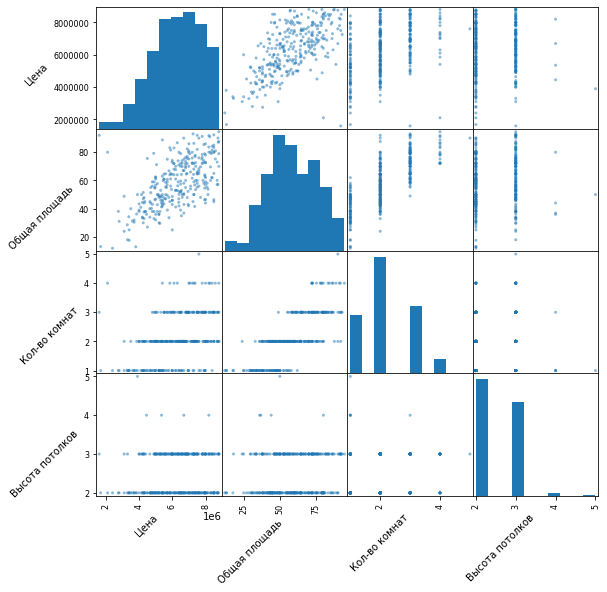

,Цена,Площадь кухни,Жилая площадь,Балкон,Число парков в радиусе 3 км,Число водоёмов в радиусе 3 км
Цена,1.000000,0.306510,0.541430,0.077869,0.104955,-0.105093
Площадь кухни,0.306510,1.000000,0.042381,0.076850,0.015633,-0.076274
Жилая площадь,0.541430,0.042381,1.000000,-0.086971,0.035211,0.057323
Балкон,0.077869,0.076850,-0.086971,1.000000,-0.123027,-0.011866
Число парков в радиусе 3 км,0.104955,0.015633,0.035211,-0.123027,1.000000,0.143546
Число водоёмов в радиусе 3 км,-0.105093,-0.076274,0.057323,-0.011866,0.143546,1.000000


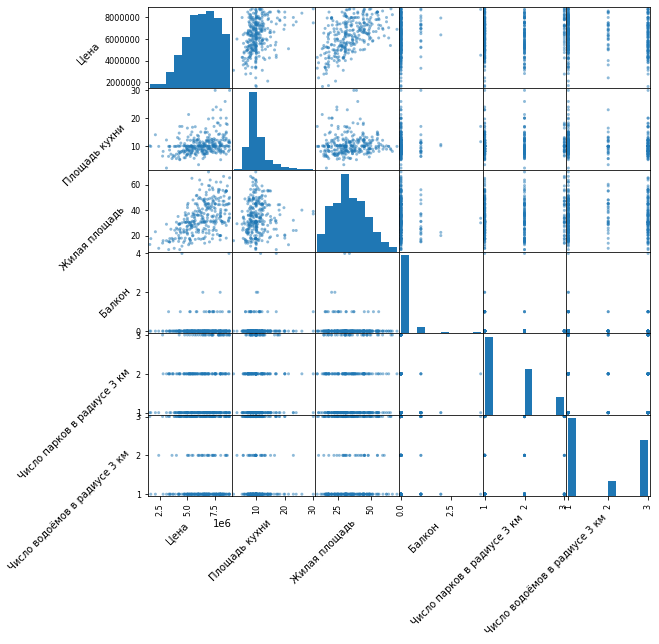

In [ ]:
spb=spb.query('cityCenters_nearest_km <= 5')
spb=spb.rename(columns={"last_price": "Цена", "total_area": "Общая площадь", "rooms": "Кол-во комнат", "ceiling_height": "Высота потолков", "kitchen_area": "Площадь кухни", "living_area": "Жилая площадь",'balcony':'Балкон','parks_around3000': 'Число парков в радиусе 3 км', 'ponds_around3000':'Число водоёмов в радиусе 3 км'})
columns1 = ["Цена", "Общая площадь", "Кол-во комнат", "Высота потолков"]
columns2 = ["Цена", "Площадь кухни", "Жилая площадь", 'Балкон','Число парков в радиусе 3 км', 'Число водоёмов в радиусе 3 км']

dict_for_auto = [columns1, columns2]
 
for columns in dict_for_auto:
    display(spb[columns].corr())
    ax=pd.plotting.scatter_matrix(spb[columns], figsize=(9, 9))
    for ax in ax.flatten():
        ax.xaxis.label.set_rotation(45)
        ax.xaxis.label.set_ha('right')
        ax.yaxis.label.set_rotation(45)
        ax.yaxis.label.set_ha('right')
    plt.show()

Также жилая площадь и площадь кухни имеют влияние, дополнительные же факторы оказывают слабое влияние на ценообразование

## Шаг 5. Общий вывод

Цены на квартиры как в центре Санкт-Петербурга, так и в целом по датасету зависят в первую очередь от общей площади, а также от  жилой площади и площади кухни, в меньшей степени от количества комнат. Остальные факторы оказывают на ценообразование меньшее влияние.

При работе с датасетом были выполнениы следующие шаги:
1. Предобработка данных: определены и изучены пропущенные значения, данные приведены к нужным типам и удалены дубликаты.
2. Посчитаны и добавлены в таблицу: цена квадратного метра, день, месяц и год публикации объявления, этаж квартиры (первый, последний, другой), рассчитаны соотношения жилой и общей площади, а также отношение площади кухни к общей плоади.
3. Проведен исследовательский анализ данных как по всему датасету, там и с выделением отдельных групп данных.

Цены на квартиры как в центре Санкт-Петербурга, так и в целом по датасету зависят в первую очередь от общей площади, а также от  жилой площади и площади кухни, в меньшей степени от количества комнат. Остальные факторы оказывают на ценообразование меньшее влияние.

При моделировании автоматизированной системы необходимо в первую очередь ориентироваться на следующие параметры: общая площадь, жилая площадь и площадь кухни, а также количество комнат.